In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from collections import Counter
import tensorflow as tf
from pathlib import Path
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from scipy.optimize import minimize
from sklearn.metrics import cohen_kappa_score

# Chapter 1
* Data Load
* Preprosesing
* Make Data Train Balanced
* Create Image Data Generator

## Load The Dataset

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("benjaminwarner/resized-2015-2019-blindness-detection-images")

print("Path to dataset files:", path)

100%|██████████| 17.3G/17.3G [13:45<00:00, 22.5MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/benjaminwarner/resized-2015-2019-blindness-detection-images/versions/1


In [3]:
os.listdir(path)

['labels',
 'resized train 19',
 'resized train 15',
 'resized test 15',
 'resized test 19']

In [4]:

os.listdir(path+"/labels")

['testLabels15.csv',
 'trainLabels19.csv',
 'trainLabels15.csv',
 'testImages19.csv']

In [5]:
train_df_19=pd.read_csv(path+"/labels/trainLabels19.csv")
train_df_15=pd.read_csv(path+"/labels/trainLabels15.csv")

In [6]:
train_df_15.head()

,image,level
0,10_left,0
1,10_right,0
2,13_left,0
3,13_right,0
4,15_left,1


<Axes: xlabel='level', ylabel='count'>

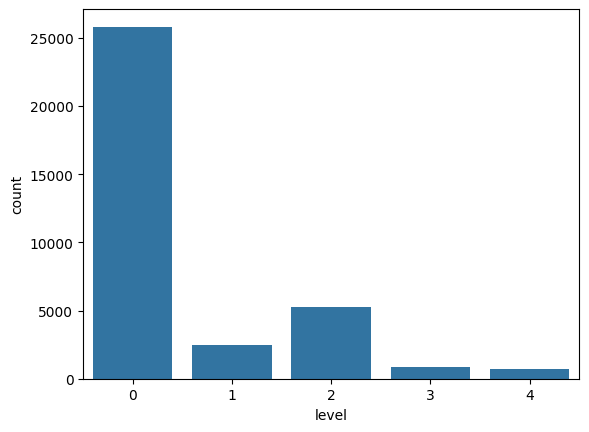

In [7]:
sns.countplot(data=train_df_15,x='level')

In [8]:
train_df_19.head()

,id_code,diagnosis
0,000c1434d8d7,2
1,001639a390f0,4
2,0024cdab0c1e,1
3,002c21358ce6,0
4,005b95c28852,0


<Axes: xlabel='diagnosis', ylabel='count'>

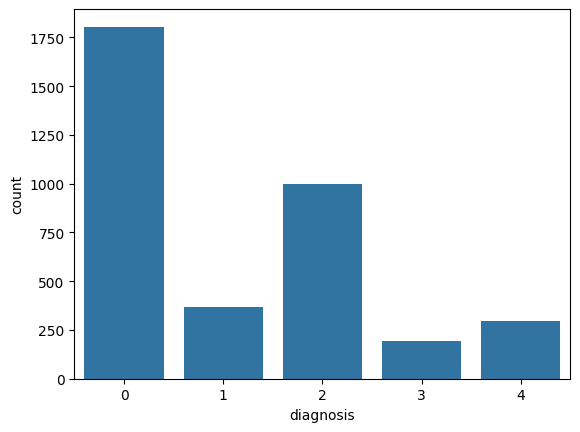

In [9]:
sns.countplot(data=train_df_19,x='diagnosis')

## Combine The Two Datasets

In [10]:
train_df_15.rename(columns={'image':'id_code','level':'diagnosis'},inplace=True)


In [11]:

train_df_15_2=train_df_15[train_df_15['diagnosis']==2]
train_df_15_2=train_df_15_2.sample(n=500,random_state=2)


In [12]:
train_df_15_1=train_df_15[train_df_15['diagnosis']==1].sample(n=1000,random_state=2)
train_df_15_3=train_df_15[train_df_15['diagnosis']==3]
train_df_15_4=train_df_15[train_df_15['diagnosis']==4]

In [13]:
train_df_15=pd.concat([train_df_15_1,train_df_15_2,train_df_15_3,train_df_15_4],ignore_index=True)

In [14]:
#train_df_15_other=train_df_15[train_df_15['diagnosis']!=0]

In [15]:
#train_df_15=pd.concat([train_df_15_0,train_df_15_other],ignore_index=True)

<Axes: xlabel='diagnosis', ylabel='count'>

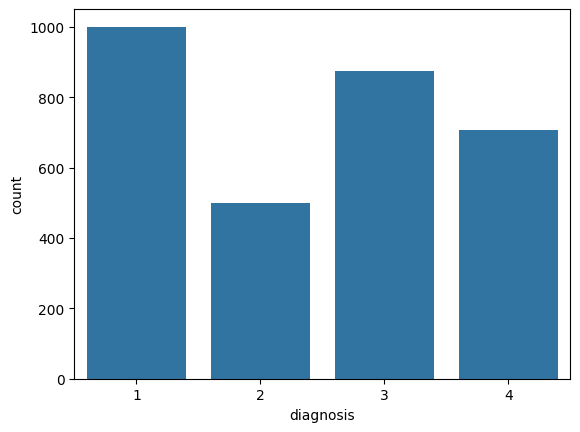

In [16]:
sns.countplot(data=train_df_15,x='diagnosis')

In [17]:

train_df_15['image_folder'] = os.path.join(path, "resized train 15")


In [18]:
train_df_19['image_folder'] = os.path.join(path, "resized train 19")
train_df=pd.concat([train_df_15,train_df_19], ignore_index=True)

<Axes: xlabel='diagnosis', ylabel='count'>

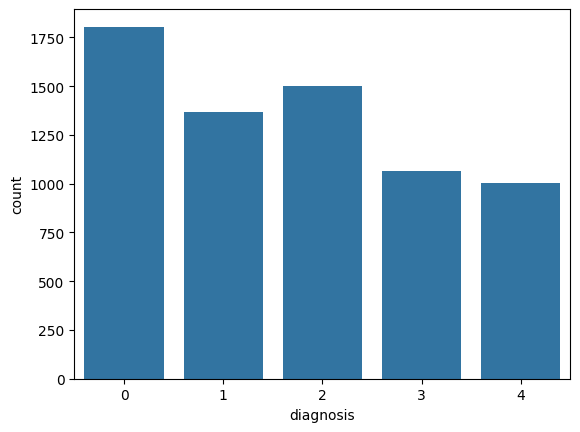

In [19]:
sns.countplot(data=train_df,x='diagnosis')

In [20]:
train_df.head()

,id_code,diagnosis,image_folder
0,41688_right,1,/root/.cache/kagglehub/datasets/benjaminwarner...
1,42981_right,1,/root/.cache/kagglehub/datasets/benjaminwarner...
2,31981_right,1,/root/.cache/kagglehub/datasets/benjaminwarner...
3,5720_left,1,/root/.cache/kagglehub/datasets/benjaminwarner...
4,10672_left,1,/root/.cache/kagglehub/datasets/benjaminwarner...


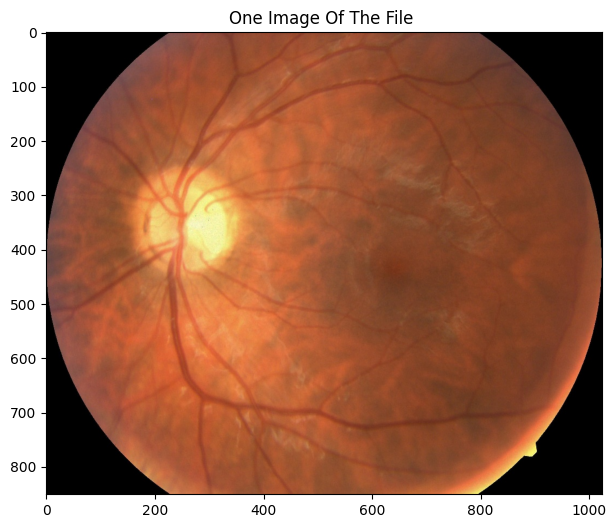

In [21]:
plt.figure(figsize=(10, 6))
plt.title('One Image Of The File ')

image_dir = train_df['image_folder'][0]
image_filename = os.listdir(image_dir)[0]
full_image_path = os.path.join(image_dir, image_filename)

image_data = plt.imread(full_image_path)
plt.imshow(image_data)

In [22]:
total_images=len(train_df)
print(f"Total Images: {total_images}")

Total Images: 6743


## Plot Some Images

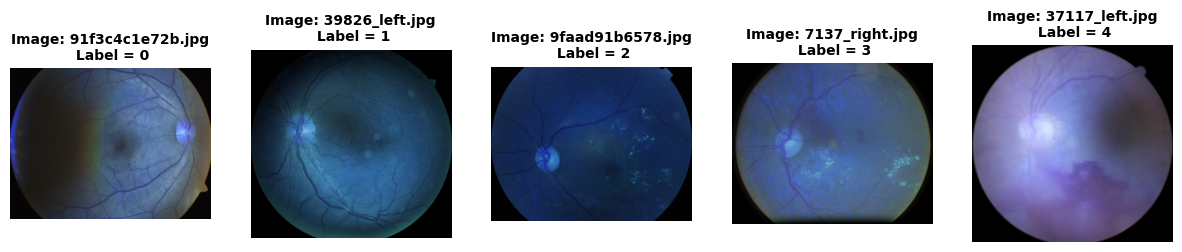

In [ ]:
fig, ax = plt.subplots(1, 5, figsize=(15, 6))
for i in range(5):
    sample = train_df[train_df['diagnosis'] == i].sample(1)
    image_name = sample['id_code'].item()

    image_path = os.path.join(sample['image_folder'].item(), f"{image_name}.jpg")

    X = cv2.imread(image_path)

    if X is None:
        print(f"Warning: Could not read image at {image_path}. Skipping plot for this sample.")
        continue
    ax[i].set_title(f"Image: {image_name}.jpg\n Label = {sample['diagnosis'].item()}",
                    weight='bold', fontsize=10)
    ax[i].axis('off')
    ax[i].imshow(X);

## (DO NOT RUN IT) Make Semi-Balanced Train Dataset (DO NOT RUN IT)

In [ ]:
IM_SIZE = 600
print(f"IM_SIZE defined as: {IM_SIZE}")

IM_SIZE defined as: 600


In [ ]:
def create_augmentation_layer():
    """Augmentation for balancing: flips, rotation, crop, zoom"""
    return tf.keras.Sequential(
        [
            tf.keras.layers.RandomFlip("horizontal"),
            tf.keras.layers.RandomFlip("vertical"),
            tf.keras.layers.RandomRotation(0.8, fill_mode="constant"),  # ~15 degrees
            tf.keras.layers.RandomZoom(0.2),
        ]
    )

In [ ]:
def create_balanced_dataset(train_df, output_dir, target_total_per_class, min_images_per_class, augmentation_function, im_size):
    Path(output_dir).mkdir(parents=True, exist_ok=True)

    balanced_data = []
    unique_diagnoses = sorted(train_df['diagnosis'].unique())

    for diagnosis_level in unique_diagnoses:
        class_df = train_df[train_df['diagnosis'] == diagnosis_level]
        current_count = len(class_df)
        print(f"Processing diagnosis level {diagnosis_level}: Current count = {current_count}")

        # Determine the target count for this class
        target_count = max(target_total_per_class.get(diagnosis_level, 0), min_images_per_class)
        print(f"Target count for diagnosis level {diagnosis_level} = {target_count}")

        # Copy original images to the new directory
        for index, row in class_df.iterrows():
            original_image_path = os.path.join(row['image_folder'], f"{row['id_code']}.jpg")
            new_image_filename = f"{row['id_code']}.jpg"
            new_image_path = os.path.join(output_dir, new_image_filename)

            # Read and resize image before saving
            img = cv2.imread(original_image_path)
            if img is None:
                print(f"Warning: Could not read image {original_image_path}. Skipping.")
                continue
            img = cv2.resize(img, (im_size, im_size))
            cv2.imwrite(new_image_path, img)
            balanced_data.append({'id_code': row['id_code'], 'diagnosis': diagnosis_level, 'relative_path': new_image_filename})

        # Augment images if necessary
        num_to_augment = target_count - current_count
        if num_to_augment > 0:
            print(f"Augmenting {num_to_augment} images for diagnosis level {diagnosis_level}")
            # Get paths to the images that will be augmented
            # We use a random sample of existing images for augmentation
            images_for_augmentation = class_df.sample(n=min(current_count, num_to_augment), replace=True)

            for i in range(num_to_augment):
                # Select an image to augment (randomly if num_to_augment > current_count)
                sample_row = images_for_augmentation.sample(1).iloc[0]
                original_image_path = os.path.join(sample_row['image_folder'], f"{sample_row['id_code']}.jpg")

                img = cv2.imread(original_image_path)
                if img is None:
                    print(f"Warning: Could not read image {original_image_path} for augmentation. Skipping.")
                    continue

                # Resize before augmentation for consistent input size
                img = cv2.resize(img, (im_size, im_size))
                # Convert to TF Tensor, apply augmentation, convert back to numpy
                augmented_img_tf = augmentation_function(tf.expand_dims(tf.convert_to_tensor(img), 0))
                augmented_img_np = augmented_img_tf[0].numpy().astype(np.uint8)

                new_image_filename = f"{sample_row['id_code']}_aug_{i}.jpg"
                new_image_path = os.path.join(output_dir, new_image_filename)
                cv2.imwrite(new_image_path, augmented_img_np)
                balanced_data.append({'id_code': f"{sample_row['id_code']}_aug_{i}", 'diagnosis': diagnosis_level, 'relative_path': new_image_filename})

    return pd.DataFrame(balanced_data)

print("create_balanced_dataset function defined.")

create_balanced_dataset function defined.


In [ ]:
output_dir = 'balanced_train_dataset'

# Get current class counts to inform target counts
class_counts = train_df['diagnosis'].value_counts().sort_index()
print(f"Original class counts:\n{class_counts}")

# Define target counts: augment minority classes up to a minimum, keep majority classes as is
min_images_per_class = 4000 # Example minimum, can be adjusted
target_total_per_class = {}
for diagnosis_level in sorted(train_df['diagnosis'].unique()):
    current_count = class_counts.get(diagnosis_level, 0)
    if current_count < min_images_per_class:
        target_total_per_class[diagnosis_level] = min_images_per_class
    else:
        target_total_per_class[diagnosis_level] = current_count

print(f"Target images per class:\n{target_total_per_class}")

# Create the augmentation layer instance
augmentation_layer = create_augmentation_layer()

# Call the function to create the balanced dataset
balanced_train_df = create_balanced_dataset(train_df,
                                            output_dir,
                                            target_total_per_class,
                                            min_images_per_class,
                                            augmentation_layer,
                                            IM_SIZE)

print("Balanced dataset created.")

Original class counts:
diagnosis
0    6805
1    2813
2    6291
3    1066
4    1003
Name: count, dtype: int64
Target images per class:
{np.int64(0): np.int64(6805), np.int64(1): 4000, np.int64(2): np.int64(6291), np.int64(3): 4000, np.int64(4): 4000}
Processing diagnosis level 0: Current count = 6805
Target count for diagnosis level 0 = 6805
Processing diagnosis level 1: Current count = 2813
Target count for diagnosis level 1 = 4000
Augmenting 1187 images for diagnosis level 1
Processing diagnosis level 2: Current count = 6291
Target count for diagnosis level 2 = 6291
Processing diagnosis level 3: Current count = 1066
Target count for diagnosis level 3 = 4000
Augmenting 2934 images for diagnosis level 3
Processing diagnosis level 4: Current count = 1003
Target count for diagnosis level 4 = 4000
Augmenting 2997 images for diagnosis level 4
Balanced dataset created.


<Axes: xlabel='diagnosis', ylabel='count'>

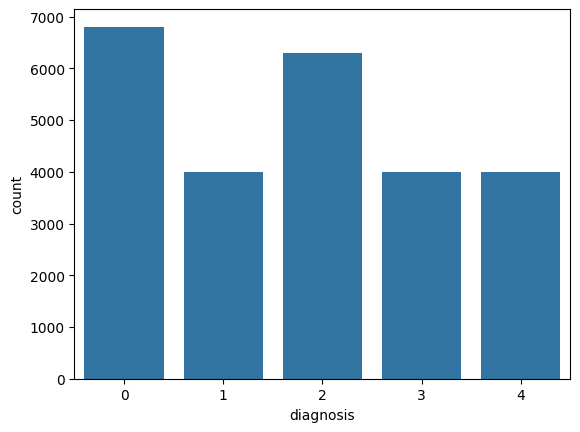

In [ ]:
sns.countplot(data=balanced_train_df,x='diagnosis')

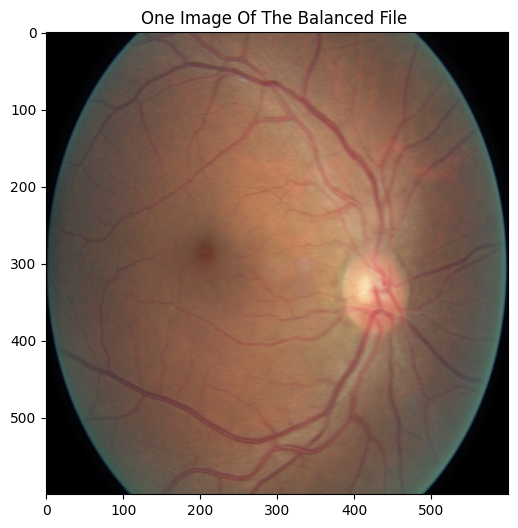

In [ ]:
plt.figure(figsize=(10, 6))
plt.title('One Image Of The Balanced File ')

full_image_path = os.path.join(output_dir, balanced_train_df['relative_path'][0])

image_data = plt.imread(full_image_path)
plt.imshow(image_data)

In [ ]:
balanced_train_df[]

In [ ]:
balanced_train_df['full_path'] = balanced_train_df['relative_path'].apply(lambda x: os.path.join(output_dir, x))

display(balanced_train_df.head())

,id_code,diagnosis,relative_path,full_path
0,40576_left,0,40576_left.jpg,balanced_train_dataset/40576_left.jpg
1,33112_left,0,33112_left.jpg,balanced_train_dataset/33112_left.jpg
2,31961_right,0,31961_right.jpg,balanced_train_dataset/31961_right.jpg
3,2515_left,0,2515_left.jpg,balanced_train_dataset/2515_left.jpg
4,40364_right,0,40364_right.jpg,balanced_train_dataset/40364_right.jpg


## Make The Validation Set

In [23]:
os.listdir(path+"/labels")

['testLabels15.csv',
 'trainLabels19.csv',
 'trainLabels15.csv',
 'testImages19.csv']

In [24]:

test_df_15=pd.read_csv(path+"/labels/testLabels15.csv")

In [25]:
test_df_15.drop(columns=['Usage'],inplace=True)
test_df_15.head()

,image,level
0,1_left,0
1,1_right,0
2,2_left,0
3,2_right,0
4,3_left,2


<Axes: xlabel='level', ylabel='count'>

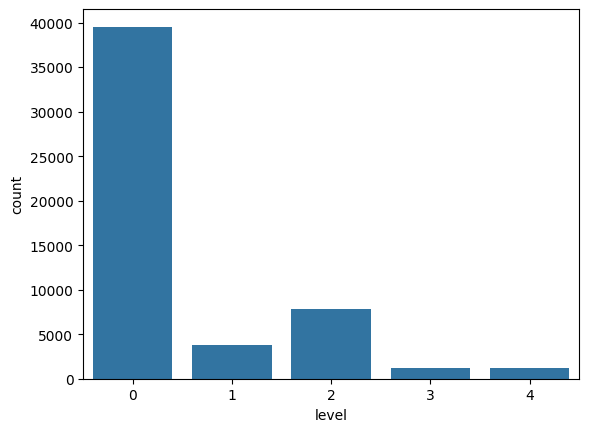

In [26]:
sns.countplot(data=test_df_15,x='level')

In [27]:
sampled_dfs = []
# Assuming diagnosis levels are 0-4 based on previous countplots
for i in range(5):
    class_df = test_df_15[test_df_15['level'] == i]
    n_samples = min(100, len(class_df))
    if n_samples > 0:
        sample = class_df.sample(n=n_samples, random_state=0)
        sampled_dfs.append(sample)
    else:
        print(f"Warning: No samples found for level {i} in test_df_15.")

if sampled_dfs:
    test_df_15 = pd.concat(sampled_dfs, ignore_index=True)
    print(f"Validation dataset created with {len(test_df_15)} samples.")
else:
    print("No samples were collected. test_df_15 remains unchanged or becomes empty.")


Validation dataset created with 500 samples.


In [28]:
test_df_15['level'].value_counts()

,count
level,
0,100
1,100
2,100
3,100
4,100


In [29]:
test_images_dir = os.path.join(path, "resized test 15")

In [30]:
test_df_15['full_path'] = test_df_15['image'].apply(lambda x: os.path.join(test_images_dir, x+'.jpg'))

In [31]:
test_df_15['full_path'][0]

'/root/.cache/kagglehub/datasets/benjaminwarner/resized-2015-2019-blindness-detection-images/versions/1/resized test 15/43788_left.jpg'

## Resize+CLAHE

In [32]:
#IM_SIZE=512 #FOR MY EF_B7&InceptionV3
IM_SIZE=224 #FOR MY VGG16
#IM_SIZE=456 #FOR MY E_B5
#IM_SIZE=384 #FOR MY ViT

In [33]:
import cv2
import numpy as np

def apply_clahe(image):

    if image.dtype != np.uint8:

        if image.max() <= 1.0 and image.min() >= 0.0:
            image = (image * 255).astype(np.uint8)
        else:

            image = image.astype(np.uint8)


    if len(image.shape) == 3 and image.shape[2] == 3:
        lab = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)

        l_channel, a_channel, b_channel = cv2.split(lab)

        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        cl = clahe.apply(l_channel)

        limg = cv2.merge((cl, a_channel, b_channel))

        enhanced_image = cv2.cvtColor(limg, cv2.COLOR_LAB2RGB)
    elif len(image.shape) == 2:
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        enhanced_image = clahe.apply(image)
    else:
        raise ValueError("Unsupported image format. Image must be grayscale or 3-channel color.")

    return enhanced_image

In [34]:
def crop_image1(img,tol=7):
    # img is image data
    # tol  is tolerance

    mask = img>tol
    return img[np.ix_(mask.any(1),mask.any(0))]

def crop_image_from_gray(img,tol=7):
    if img.ndim ==2:
        mask = img>tol
        return img[np.ix_(mask.any(1),mask.any(0))]
    elif img.ndim==3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img>tol

        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if (check_shape == 0): # image is too dark so that we crop out everything,
            return img # return original image
        else:
            img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
    #         print(img1.shape,img2.shape,img3.shape)
            img = np.stack([img1,img2,img3],axis=-1)
    #         print(img.shape)
        return img
def load_ben_color(image, sigmaX=30):
    #image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = crop_image_from_gray(image)
    image = cv2.resize(image, (IM_SIZE, IM_SIZE))
    image=cv2.addWeighted ( image,4, cv2.GaussianBlur( image , (0,0) , sigmaX) ,-4 ,128)

    return image

In [35]:
import cv2
import numpy as np

def apply_clahe(image, clip_limit=2.5, grid_size=(8, 8)):
    """
    Applies CLAHE to a color image by converting to LAB color space.
    - clip_limit: Threshold for contrast limiting.
    - grid_size: Size of the grid for the histogram equalization.
    """
    # 1. Convert from RGB to LAB color space
    # L = Lightness, A & B = Color dimensions
    lab = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
    l_channel, a_channel, b_channel = cv2.split(lab)

    # 2. Create CLAHE object
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=grid_size)

    # 3. Apply CLAHE to the L channel only
    cl = clahe.apply(l_channel)

    # 4. Merge channels back and convert to RGB
    merged_lab = cv2.merge((cl, a_channel, b_channel))
    final_image = cv2.cvtColor(merged_lab, cv2.COLOR_LAB2RGB)

    return final_image

In [54]:
def image_resize(image):
  # ImageDataGenerator passes float32 images (typically 0-255 range for preprocessing_function).
  # Convert to uint8 for OpenCV operations that require it.
  if image.dtype != np.uint8:
    image = image.astype(np.uint8)

  # Convert to RGB to ensure consistency for subsequent operations
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

  # Apply cropping before resizing
  image = crop_image_from_gray(image)

  # Resize the image
  image = cv2.resize(image, (IM_SIZE, IM_SIZE))

  # Apply CLAHE
  image = apply_clahe(image)
  image / 255.0


  # Normalize for model input (0-1 range)
  return image

In [ ]:
def master_preprocess(image, img_size=IM_SIZE):
    # ImageDataGenerator passes float32 images (0-255 range by default for preprocessing_function).
    # Convert to uint8 for OpenCV operations that require it.
    image = image.astype(np.uint8)

    # 1. Load and Autocrop
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    mask = gray > 7
    image = image[np.ix_(mask.any(1), mask.any(0))]

    # 2. Resize
    image = cv2.resize(image, (img_size, img_size))

    # 3. Enhance Contrast with CLAHE
    image = apply_clahe(image, clip_limit=1.0, grid_size=(8, 8))

    # 4. Optional: Add Ben Graham's blurring for extra vessel detail
    image = cv2.addWeighted(image, 4, cv2.GaussianBlur(image, (0,0), 40), -4, 128)

    # Convert back to float32 and normalize for model input
    return image.astype(np.float32) / 255.0

* The Images That The Models Will See

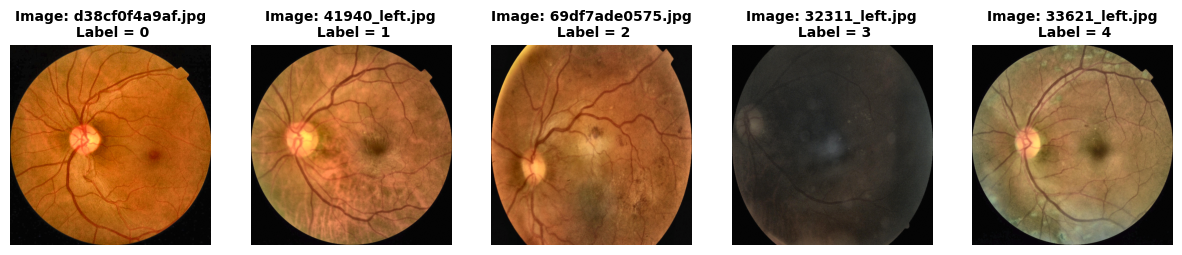

In [ ]:
fig, ax = plt.subplots(1, 5, figsize=(15, 6))
for i in range(5):
    sample = train_df[train_df['diagnosis'] == i].sample(1)
    image_name = sample['id_code'].item()

    image_path = os.path.join(sample['image_folder'].item(), f"{image_name}.jpg")

    X = cv2.imread(image_path)
    X=image_resize(X)

    if X is None:
        print(f"Warning: Could not read image at {image_path}. Skipping plot for this sample.")
        continue
    ax[i].set_title(f"Image: {image_name}.jpg\n Label = {sample['diagnosis'].item()}",
                    weight='bold', fontsize=10)
    ax[i].axis('off')
    ax[i].imshow(X);

## Create ImageDataGenerator

In [55]:
train_df['full_path'] = train_df.apply(lambda row: os.path.join(row['image_folder'], f"{row['id_code']}.jpg"), axis=1)
display(train_df.head())

,id_code,diagnosis,image_folder,full_path
0,41688_right,1,/root/.cache/kagglehub/datasets/benjaminwarner...,/root/.cache/kagglehub/datasets/benjaminwarner...
1,42981_right,1,/root/.cache/kagglehub/datasets/benjaminwarner...,/root/.cache/kagglehub/datasets/benjaminwarner...
2,31981_right,1,/root/.cache/kagglehub/datasets/benjaminwarner...,/root/.cache/kagglehub/datasets/benjaminwarner...
3,5720_left,1,/root/.cache/kagglehub/datasets/benjaminwarner...,/root/.cache/kagglehub/datasets/benjaminwarner...
4,10672_left,1,/root/.cache/kagglehub/datasets/benjaminwarner...,/root/.cache/kagglehub/datasets/benjaminwarner...


In [56]:
from numpy.random import shuffle
train_datagen = ImageDataGenerator(preprocessing_function=image_resize)

val_gen=ImageDataGenerator(preprocessing_function=image_resize)


train_gen = train_datagen.flow_from_dataframe(train_df,
                                                    x_col='full_path',
                                                    y_col='diagnosis',
                                                    directory = None,
                                                    target_size=(IM_SIZE,IM_SIZE),
                                                    batch_size=4,
                                                    class_mode='raw',
                                                    shuffle=True)


val_gen = train_datagen.flow_from_dataframe(test_df_15,
                                                  x_col='full_path',
                                                  y_col='level',
                                                  directory = None,
                                                  target_size=(IM_SIZE,IM_SIZE),
                                                  batch_size=4,
                                                  class_mode='raw',
                                                  shuffle=False)

Found 6743 validated image filenames.
Found 500 validated image filenames.


## The QWKMetric

QWK ScoreStrength of AgreementWhat it means in practice:
* < 0PoorThe agreement is worse than random chance. Something is wrong.
* 0.0 – 0.20 SlightThere is a very tiny correlation, but mostly noise.
* 0.21 – 0.40 FairSome agreement, but the raters are inconsistent.
* 0.41 – 0.60 ModerateDecent agreement. This is often the minimum for "acceptable" AI performance.
* 0.61 – 0.80 This is a strong result.Raters are mostly in sync.
* 0.81 – 1.00 Almost PerfectExtremely high consistency. Rarely achieved in subjective tasks.

In [39]:

import numpy as np
import tensorflow as tf
from sklearn.metrics import cohen_kappa_score

class QWKRegressionCallback(tf.keras.callbacks.Callback):
    def __init__(self, val_gen, model_name='best_model.keras', thresholds=None):
        super().__init__()
        self.val_gen = val_gen
        self.model_name = model_name
        self.best_kappa = -1

        # Default thresholds for 5 classes (0,1,2,3,4)
        self.thresholds = thresholds if thresholds is not None else [0.5, 1.5, 2.5, 3.5]

        # Ensure shuffle is off for the validation generator
        if hasattr(val_gen, 'shuffle'):
            if val_gen.shuffle:
                print("⚠️ Warning: validation generator should have shuffle=False for accurate QWK calculation.")

        # Extract labels safely
        self.y_true = np.array(val_gen.labels)

    def on_epoch_end(self, epoch, logs=None):
        self.val_gen.reset()

        # Get continuous predictions
        y_pred_continuous = self.model.predict(self.val_gen, verbose=0).flatten()

        # Use digitize for cleaner thresholding
        # np.digitize returns the index of the bin the value belongs to
        y_pred_discrete = np.digitize(y_pred_continuous, self.thresholds)

        # Clip to ensure valid range (e.g., 0 to 4)
        y_pred_discrete = np.clip(y_pred_discrete, 0, len(self.thresholds))

        # Calculate Score
        val_kappa = cohen_kappa_score(self.y_true, y_pred_discrete, weights='quadratic')

        print(f"\nEpoch {epoch + 1}: val_qwk: {val_kappa:.4f}")

        # Save if best
        if val_kappa > self.best_kappa:
            self.best_kappa = val_kappa
            self.model.save(self.model_name)
            print(f"✅ Saved new best model with QWK: {val_kappa:.4f}")

# Chapter 2 (The Regression Models)
* VGG16 Regression Run
* EfficientNetB7
* InceptionV3 Regression Run
* InceptionV4 Regression Run
* ViT Regression Run
*

## VGG16

In [ ]:
IM_SIZE=224

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(IM_SIZE, IM_SIZE, 3))

base_model.trainable = True

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


* For Attention

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Reshape, Multiply

x = base_model.output

ap = tf.keras.layers.GlobalAveragePooling2D()(x)

attention_probs = tf.keras.layers.Dense(64, activation='relu')(ap)

attention_probs = tf.keras.layers.Dense(512, activation='sigmoid')(attention_probs)

attention_probs = Reshape((1, 1, 512))(attention_probs)

attended_output = Multiply()([x, attention_probs])

x = tf.keras.layers.GlobalAveragePooling2D()(attended_output)

x = tf.keras.layers.Dense(256, activation='relu')(x)

output_layer = tf.keras.layers.Dense(1, activation='linear')(x)


In [ ]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath='VGG_REG_TOP.keras',monitor='val_loss',save_best_only=True,verbose=1)
early_stop_it=tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=4,restore_best_weights=True,mode='min')

In [ ]:
model=tf.keras.Model(inputs=base_model.input,outputs=output_layer)

In [ ]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001,
    rho=0.9,
    momentum=0.0,
    epsilon=1e-07),
              loss='mse', metrics=['mae'] )
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 524, 524,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 524, 524,  │      1,792 │ input_layer_2[0]… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, 524, 524,  │     36,928 │ block1_conv1[0][… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_pool         │ (None, 262, 262,  │          0 │ block1_conv2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_conv1        │ (None, 262, 262,  │     73,856 │ block1_pool[0][0] │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_conv2        │ (None, 262, 262,  │    147,584 │ block2_conv1[0][… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, 131, 131,  │          0 │ block2_conv2[0][… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv1        │ (None, 131, 131,  │    295,168 │ block2_pool[0][0] │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv2        │ (None, 131, 131,  │    590,080 │ block3_conv1[0][… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv3        │ (None, 131, 131,  │    590,080 │ block3_conv2[0][… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_pool         │ (None, 65, 65,    │          0 │ block3_conv3[0][… │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv1        │ (None, 65, 65,    │  1,180,160 │ block3_pool[0][0] │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv2        │ (None, 65, 65,    │  2,359,808 │ block4_conv1[0][… │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv3        │ (None, 65, 65,    │  2,359,808 │ block4_conv2[0][… │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_pool         │ (None, 32, 32,    │          0 │ block4_conv3[0][… │
│ (MaxPooling2D)      │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block5_conv1        │ (None, 32, 32,    │  2,359,808 │ block4_pool[0][0] │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block5_conv2        │ (None, 32, 32,    │  2,359,808 │ block5_conv1[0][

 Total params: 14,912,385 (56.89 MB)

 Trainable params: 197,697 (772.25 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [ ]:


model.fit(train_gen,validation_data=val_gen,epochs=30,callbacks=[model_checkpoint_callback,early_stop_it])

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
785/785 ━━━━━━━━━━━━━━━━━━━━ 985s 1s/step - loss: 1.8525 - mae: 0.9672 - val_loss: 1.4663 - val_mae: 0.9985
Epoch 2/30
785/785 ━━━━━━━━━━━━━━━━━━━━ 915s 1s/step - loss: 0.8274 - mae: 0.7355 - val_loss: 1.7207 - val_mae: 1.0863
Epoch 3/30
785/785 ━━━━━━━━━━━━━━━━━━━━ 915s 1s/step - loss: 0.7544 - mae: 0.6992 - val_loss: 1.2039 - val_mae: 0.8964
Epoch 4/30
785/785 ━━━━━━━━━━━━━━━━━━━━ 912s 1s/step - loss: 0.7202 - mae: 0.6784 - val_loss: 1.2699 - val_mae: 0.9165
Epoch 5/30
785/785 ━━━━━━━━━━━━━━━━━━━━ 969s 1s/step - loss: 0.6888 - mae: 0.6591 - val_loss: 1.1279 - val_mae: 0.8517
Epoch 6/30
785/785 ━━━━━━━━━━━━━━━━━━━━ 897s 1s/step - loss: 0.6699 - mae: 0.6491 - val_loss: 1.0574 - val_mae: 0.8165
Epoch 7/30
785/785 ━━━━━━━━━━━━━━━━━━━━ 934s 1s/step - loss: 0.6312 - mae: 0.6312 - val_loss: 1.2829 - val_mae: 0.9110
Epoch 8/30
785/785 ━━━━━━━━━━━━━━━━━━━━ 916s 1s/step - loss: 0.6097 - mae: 0.6169 - val_loss: 1.2048 - val_mae: 0.8880
Epoch 9/30
785/785 ━━━━━━━━━━━━━━━━━━━━ 921s 1s/

In [ ]:
model = tf.keras.models.load_model('/content/VGG_REG_TOP (4).keras')
model.compile(optimizer=tf.keras.optimizers.Nadam(1e-3), loss='mse', metrics=['mae'] )

### Continue Training the Loaded Model

In [ ]:

model.fit(train_gen,
          validation_data=val_gen,
          epochs=30,
          callbacks=[model_checkpoint_callback, early_stop_it],initial_epoch=14)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 15/30
785/785 ━━━━━━━━━━━━━━━━━━━━ 1046s 1s/step - loss: 0.6179 - mae: 0.6302 - val_loss: 1.1796 - val_mae: 0.8786
Epoch 16/30
785/785 ━━━━━━━━━━━━━━━━━━━━ 953s 1s/step - loss: 0.6116 - mae: 0.6273 - val_loss: 1.1698 - val_mae: 0.8743
Epoch 17/30
785/785 ━━━━━━━━━━━━━━━━━━━━ 952s 1s/step - loss: 0.6020 - mae: 0.6212 - val_loss: 1.1869 - val_mae: 0.8808
Epoch 18/30
785/785 ━━━━━━━━━━━━━━━━━━━━ 952s 1s/step - loss: 0.6018 - mae: 0.6232 - val_loss: 1.1874 - val_mae: 0.8804
Epoch 19/30
785/785 ━━━━━━━━━━━━━━━━━━━━ 951s 1s/step - loss: 0.5986 - mae: 0.6191 - val_loss: 1.1983 - val_mae: 0.8844
Epoch 20/30
785/785 ━━━━━━━━━━━━━━━━━━━━ 952s 1s/step - loss: 0.5944 - mae: 0.6149 - val_loss: 1.1828 - val_mae: 0.8786


## EfficientNetB7 Run

In [ ]:
IM_SIZE=512

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB7
from tensorflow.keras import layers, models

base_model = EfficientNetB7(weights='imagenet', include_top=False, input_shape=(IM_SIZE, IM_SIZE, 3))

base_model.trainable = True

258076736/258076736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


* For Attention

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Reshape, Multiply

x = base_model.output

ap = tf.keras.layers.GlobalAveragePooling2D()(x)

attention_probs = tf.keras.layers.Dense(64, activation='relu')(ap)

attention_probs = tf.keras.layers.Dense(2560, activation='sigmoid')(attention_probs)

attention_probs = Reshape((1, 1, 2560))(attention_probs)

attended_output = Multiply()([x, attention_probs])

x = tf.keras.layers.GlobalAveragePooling2D()(attended_output)
x = tf.keras.layers.Dense(256, activation='relu')(x)

output_layer = tf.keras.layers.Dense(1, activation='linear')(x)

In [ ]:
model=tf.keras.Model(inputs=base_model.input,outputs=output_layer)

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Nadam(learning_rate=1e-4),loss=tf.keras.losses.Huber(delta=1.0), metrics=['mae'] )


In [ ]:
def schedule_fn(epoch, lr):
    start_lr = 0.0006
    end_lr = 1e-5
    total_epochs = 20

    if epoch < total_epochs:
        gamma = (end_lr / start_lr) ** (1 / total_epochs)
        return start_lr * (gamma ** epoch)
    else:
        return end_lr

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(schedule_fn)

In [ ]:
qwk=QWKRegressionCallback(val_gen, thresholds=[0.7, 1.5, 2.5, 3.5])
history=model.fit(train_gen,epochs=30,callbacks=[qwk,lr_scheduler])

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
1686/1686 ━━━━━━━━━━━━━━━━━━━━ 0s 683ms/step - loss: 0.4901 - mae: 0.8388
Epoch 1: val_qwk: 0.6303
✅ Saved new best model with QWK: 0.6303
1686/1686 ━━━━━━━━━━━━━━━━━━━━ 1540s 722ms/step - loss: 0.4901 - mae: 0.8387 - learning_rate: 1.0000e-04
Epoch 2/30
1686/1686 ━━━━━━━━━━━━━━━━━━━━ 0s 595ms/step - loss: 0.2126 - mae: 0.4989
Epoch 2: val_qwk: 0.6442
✅ Saved new best model with QWK: 0.6442
1686/1686 ━━━━━━━━━━━━━━━━━━━━ 1050s 622ms/step - loss: 0.2126 - mae: 0.4989 - learning_rate: 8.9125e-05
Epoch 3/30
1686/1686 ━━━━━━━━━━━━━━━━━━━━ 0s 595ms/step - loss: 0.1390 - mae: 0.3754
Epoch 3: val_qwk: 0.5979
1686/1686 ━━━━━━━━━━━━━━━━━━━━ 1023s 607ms/step - loss: 0.1390 - mae: 0.3754 - learning_rate: 7.9433e-05
Epoch 4/30
1686/1686 ━━━━━━━━━━━━━━━━━━━━ 0s 595ms/step - loss: 0.0919 - mae: 0.2955
Epoch 4: val_qwk: 0.6595
✅ Saved new best model with QWK: 0.6595
1686/1686 ━━━━━━━━━━━━━━━━━━━━ 1064s 631ms/step - loss: 0.0919 - mae: 0.2955 - learning_rate: 7.0795e-05
Epoch 5/30
1686/1686

In [ ]:
model=tf.keras.models.load_model("/content/b7_mixed_074qwk.keras")
qwk=QWKRegressionCallback(val_gen, thresholds=[0.7, 1.5, 2.5, 3.5])
history=model.fit(train_gen,epochs=30,callbacks=[qwk,lr_scheduler],initial_epoch=11)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 12/30
1686/1686 ━━━━━━━━━━━━━━━━━━━━ 0s 678ms/step - loss: 0.0190 - mae: 0.1130
Epoch 12: val_qwk: 0.6818
✅ Saved new best model with QWK: 0.6818
1686/1686 ━━━━━━━━━━━━━━━━━━━━ 1473s 709ms/step - loss: 0.0190 - mae: 0.1130 - learning_rate: 6.3120e-05
Epoch 13/30
1686/1686 ━━━━━━━━━━━━━━━━━━━━ 0s 593ms/step - loss: 0.0207 - mae: 0.1126
Epoch 13: val_qwk: 0.7511
✅ Saved new best model with QWK: 0.7511
1686/1686 ━━━━━━━━━━━━━━━━━━━━ 1030s 611ms/step - loss: 0.0207 - mae: 0.1126 - learning_rate: 5.1435e-05
Epoch 14/30
1686/1686 ━━━━━━━━━━━━━━━━━━━━ 0s 594ms/step - loss: 0.0135 - mae: 0.0831
Epoch 14: val_qwk: 0.7524
✅ Saved new best model with QWK: 0.7524
1686/1686 ━━━━━━━━━━━━━━━━━━━━ 1054s 625ms/step - loss: 0.0135 - mae: 0.0831 - learning_rate: 4.1913e-05
Epoch 15/30
1686/1686 ━━━━━━━━━━━━━━━━━━━━ 0s 597ms/step - loss: 0.0097 - mae: 0.0692
Epoch 15: val_qwk: 0.7086
1686/1686 ━━━━━━━━━━━━━━━━━━━━ 1027s 609ms/step - loss: 0.0097 - mae: 0.0692 - learning_rate: 3.4154e-05
Epoch 16/30


## EfficientNetB5

In [ ]:
IM_SIZE=456

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB5
from tensorflow.keras import layers, models

base_model = EfficientNetB5(weights='imagenet', include_top=False, input_shape=(IM_SIZE, IM_SIZE, 3))

base_model.trainable = False

115263384/115263384 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Reshape, Multiply

x = base_model.output

ap = tf.keras.layers.GlobalAveragePooling2D()(x)

attention_probs = tf.keras.layers.Dense(64, activation='relu')(ap)

attention_probs = tf.keras.layers.Dense(2048, activation='sigmoid')(attention_probs)

attention_probs = Reshape((1, 1, 2048))(attention_probs)

attended_output = Multiply()([x, attention_probs])

x = tf.keras.layers.GlobalAveragePooling2D()(attended_output)

x = tf.keras.layers.Dense(1675, activation='relu')(x)
x=  tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)

output_layer = tf.keras.layers.Dense(1, activation='linear')(x)

In [ ]:
model=tf.keras.Model(inputs=base_model.input,outputs=output_layer)

In [ ]:
def schedule_fn(epoch, lr):
    start_lr = 0.0001
    end_lr = 1e-5
    total_epochs = 100

    if epoch < total_epochs:
        gamma = (end_lr / start_lr) ** (1 / total_epochs)
        return start_lr * (gamma ** epoch)
    else:
        return end_lr

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(schedule_fn)

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Nadam(learning_rate=1e-3), loss='mse', metrics=['mae'] )
qwk=QWKRegressionCallback(val_gen)
history=model.fit(train_gen,epochs=30,callbacks=[qwk,lr_scheduler])

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
785/785 ━━━━━━━━━━━━━━━━━━━━ 0s 531ms/step - loss: 1.1986 - mae: 0.8860
Epoch 1: val_qwk: 0.5788
✅ Saved new best model with QWK: 0.5788
785/785 ━━━━━━━━━━━━━━━━━━━━ 597s 660ms/step - loss: 1.1983 - mae: 0.8859 - learning_rate: 1.0000e-04
Epoch 2/30
785/785 ━━━━━━━━━━━━━━━━━━━━ 0s 466ms/step - loss: 0.8067 - mae: 0.7278
Epoch 2: val_qwk: 0.6200
✅ Saved new best model with QWK: 0.6200
785/785 ━━━━━━━━━━━━━━━━━━━━ 419s 534ms/step - loss: 0.8067 - mae: 0.7278 - learning_rate: 9.7724e-05
Epoch 3/30
785/785 ━━━━━━━━━━━━━━━━━━━━ 0s 477ms/step - loss: 0.7674 - mae: 0.7042
Epoch 3: val_qwk: 0.5546
785/785 ━━━━━━━━━━━━━━━━━━━━ 426s 542ms/step - loss: 0.7674 - mae: 0.7042 - learning_rate: 9.5499e-05
Epoch 4/30
785/785 ━━━━━━━━━━━━━━━━━━━━ 0s 465ms/step - loss: 0.7318 - mae: 0.6872
Epoch 4: val_qwk: 0.6325
✅ Saved new best model with QWK: 0.6325
785/785 ━━━━━━━━━━━━━━━━━━━━ 418s 533ms/step - loss: 0.7318 - mae: 0.6872 - learning_rate: 9.3325e-05
Epoch 5/30
785/785 ━━━━━━━━━━━━━━━━━━━━ 

KeyboardInterrupt: 

## ViT

In [40]:
!pip install -q tensorflow transformers


In [41]:
import tensorflow as tf
from transformers import TFViTForImageClassification, ViTImageProcessor


In [42]:
from transformers import TFViTForImageClassification, ViTImageProcessor

MODEL_NAME = "google/vit-base-patch16-224-in21k"

processor = ViTImageProcessor.from_pretrained(MODEL_NAME)

model = TFViTForImageClassification.from_pretrained(
    MODEL_NAME,
    num_labels=1,
    from_pt=True,
    use_safetensors=False
)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/346M [00:00<?, ?B/s]

TensorFlow and JAX classes are deprecated and will be removed in Transformers v5. We recommend migrating to PyTorch classes or pinning your version of Transformers.
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFViTForImageClassification: ['pooler.dense.bias', 'pooler.dense.weight']
- This IS expected if you are initializing TFViTForImageClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFViTForImageClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFViTForImageClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should proba

In [43]:
model.vit.trainable = False


In [44]:
model.compile(optimizer='nadam', loss=tf.keras.losses.Huber(delta=1.0), metrics=['mae'] )

In [59]:
def schedule_fn(epoch, lr):
    start_lr = 2e-5
    end_lr = 1e-7
    total_epochs = 20

    if epoch < total_epochs:
        gamma = (end_lr / start_lr) ** (1 / total_epochs)
        return start_lr * (gamma ** epoch)
    else:
        return end_lr

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(schedule_fn)

In [64]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import cohen_kappa_score

class QWKRegressionCallback(tf.keras.callbacks.Callback):
    def __init__(self, original_val_gen_idg, vit_data_generator_fn, model_name='best_model.keras', thresholds=None):
        super().__init__()
        self.original_val_gen_idg = original_val_gen_idg
        self.vit_data_generator_fn = vit_data_generator_fn
        self.model_name = model_name
        self.best_kappa = -1

        self.thresholds = thresholds if thresholds is not None else [0.5, 1.5, 2.5, 3.5]

        if hasattr(original_val_gen_idg, 'shuffle'):
            if original_val_gen_idg.shuffle:
                print("⚠️ Warning: validation generator should have shuffle=False for accurate QWK calculation.")

        self.y_true = np.array(original_val_gen_idg.labels)

    def on_epoch_end(self, epoch, logs=None):
        # Reset the original ImageDataGenerator to ensure predictions start from the beginning
        self.original_val_gen_idg.reset()
        # Create a fresh ViT-compatible generator for prediction for this epoch
        val_vit_gen_for_predict = self.vit_data_generator_fn(self.original_val_gen_idg)

        # Get continuous predictions
        # It's crucial to specify steps for generators in model.predict
        y_pred_continuous = self.model.predict(val_vit_gen_for_predict, verbose=0, steps=len(self.original_val_gen_idg)).flatten()

        # Use digitize for cleaner thresholding
        y_pred_discrete = np.digitize(y_pred_continuous, self.thresholds)

        # Clip to ensure valid range (e.g., 0 to 4)
        y_pred_discrete = np.clip(y_pred_discrete, 0, len(self.thresholds))

        # Calculate Score
        val_kappa = cohen_kappa_score(self.y_true, y_pred_discrete, weights='quadratic')

        print(f"\nEpoch {epoch + 1}: val_qwk: {val_kappa:.4f}")

        # Save if best
        if val_kappa > self.best_kappa:
            self.best_kappa = val_kappa
            self.model.save(self.model_name)
            print(f"✅ Saved new best model with QWK: {val_kappa:.4f}")

In [70]:
def schedule_fn(epoch, lr):
    start_lr = 2e-5
    end_lr = 1e-7
    total_epochs = 20

    if epoch < total_epochs:
        gamma = (end_lr / start_lr) ** (1 / total_epochs)
        return start_lr * (gamma ** epoch)
    else:
        return end_lr

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(schedule_fn)
# Fix: Add the missing internal attribute for compatibility with HuggingFace models
lr_scheduler._implements_train_batch_hooks = lambda: True
lr_scheduler._implements_test_batch_hooks = lambda: True
lr_scheduler._implements_predict_batch_hooks = lambda: True

def vit_data_generator(generator):
    for images, labels in generator:
        # Transpose images from (batch, H, W, C) to (batch, C, H, W)
        images_transposed = tf.transpose(images, perm=[0, 3, 1, 2])
        # Transformers models expect a dictionary for inputs
        yield {'pixel_values': images_transposed}, labels

train_vit_gen = vit_data_generator(train_gen)
val_vit_gen = vit_data_generator(val_gen)

# Instantiate the QWKRegressionCallback, passing the original val_gen (ImageDataGenerator) and the wrapper function
# The QWKRegressionCallback class definition is in cell bf50wkcedltz.
qwk_callback = QWKRegressionCallback(val_gen, vit_data_generator, model_name='vit_best_qwk.keras', thresholds=[0.7, 1.5, 2.5, 3.5])

history=model.fit(train_vit_gen,validation_data=val_vit_gen,epochs=30,callbacks=[lr_scheduler, qwk_callback])

Epoch 1/30
     26/Unknown - 2s 81ms/step - loss: 0.5263 - mae: 0.8770

KeyboardInterrupt: 

# Chapter 3 (The Classification Models)

In [ ]:
balanced_train_df['diagnosis']=balanced_train_df['diagnosis'].astype(str)
test_df_15['level']=test_df_15['level'].astype(str)

In [ ]:
train_datagen = ImageDataGenerator(preprocessing_function=image_resize)

val_gen=ImageDataGenerator(preprocessing_function=image_resize)

train_gen = train_datagen.flow_from_dataframe(balanced_train_df,
                                                    x_col='full_path',
                                                    y_col='diagnosis',
                                                    directory = None,
                                                    target_size=(IM_SIZE,IM_SIZE),
                                                    batch_size=4,
                                                    class_mode='categorical',shuffle=True)


val_gen = train_datagen.flow_from_dataframe(test_df_15,
                                                  x_col='full_path',
                                                  y_col='level',
                                                  directory = None,
                                                  target_size=(IM_SIZE,IM_SIZE),
                                                  batch_size=4,
                                                  class_mode='categorical',shuffle=False)

Found 25096 validated image filenames belonging to 5 classes.
Found 2500 validated image filenames belonging to 5 classes.


In [ ]:
classes = np.unique(balanced_train_df['diagnosis'])
class_weights = compute_class_weight('balanced', classes=classes, y=balanced_train_df['diagnosis'].values)
class_weight_dict = {c: w for c, w in zip(classes, class_weights)}


print(class_weight_dict)

{'0': np.float64(0.7375753122703894), '1': np.float64(1.2548), '2': np.float64(0.7978381815291686), '3': np.float64(1.2548), '4': np.float64(1.2548)}


## InceptionV3

In [ ]:
from tensorflow.keras.applications import InceptionV3

base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(IM_SIZE, IM_SIZE, 3))
print("Pre-trained InceptionV3 model loaded successfully.")


87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
Pre-trained InceptionV3 model loaded successfully.


In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Reshape, Multiply,GlobalAveragePooling2D,Dense


x = base_model.output

ap = GlobalAveragePooling2D()(x)

attention_probs = Dense(64, activation='relu')(ap)

attention_probs = Dense(2048, activation='sigmoid')(attention_probs)

attention_probs = Reshape((1, 1, 2048))(attention_probs)

attended_output = Multiply()([x, attention_probs])

In [ ]:
x = GlobalAveragePooling2D()(attended_output)
x = Dense(256, activation='relu')(x)
output_layer = Dense(len(classes), activation='softmax')(x)

In [ ]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath='inV3best_with_weights.keras',monitor='accuracy',save_best_only=True)
early_stop_it=tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',patience=5,restore_best_weights=True,mode='max')
rlr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy',  factor=0.2,
                                                                patience=2,
                                                                verbose=1,
                                                                mode='max',
                                                                epsilon=0.001)

In [ ]:
model = tf.keras.models.Model(inputs=base_model.input, outputs=output_layer)
model.compile(optimizer=tf.keras.optimizers.Nadam(learning_rate=1e-4),loss='categorical_crossentropy',metrics=['accuracy'])

In [ ]:
history=model.fit(train_gen,validation_data=val_gen,epochs=20,class_weight=class_weight_dict,callbacks=[model_checkpoint_callback,early_stop_it,rlr])

Epoch 1/20


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


6274/6274 ━━━━━━━━━━━━━━━━━━━━ 1457s 216ms/step - accuracy: 0.5376 - loss: 1.0944 - val_accuracy: 0.3608 - val_loss: 1.6387 - learning_rate: 1.0000e-04
Epoch 2/20
6274/6274 ━━━━━━━━━━━━━━━━━━━━ 1356s 216ms/step - accuracy: 0.6621 - loss: 0.8253 - val_accuracy: 0.4740 - val_loss: 1.1994 - learning_rate: 1.0000e-04
Epoch 3/20
6274/6274 ━━━━━━━━━━━━━━━━━━━━ 1421s 219ms/step - accuracy: 0.7102 - loss: 0.7300 - val_accuracy: 0.4712 - val_loss: 1.3568 - learning_rate: 1.0000e-04
Epoch 4/20
6274/6274 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step - accuracy: 0.7414 - loss: 0.6549
Epoch 4: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
6274/6274 ━━━━━━━━━━━━━━━━━━━━ 1343s 214ms/step - accuracy: 0.7414 - loss: 0.6549 - val_accuracy: 0.4560 - val_loss: 1.3154 - learning_rate: 1.0000e-04
Epoch 5/20
6274/6274 ━━━━━━━━━━━━━━━━━━━━ 1343s 214ms/step - accuracy: 0.8128 - loss: 0.4911 - val_accuracy: 0.5316 - val_loss: 1.2829 - learning_rate: 2.0000e-05
Epoch 6/20
6274/6274 ━━━━━━━━━━━━━━━━━━━

## Model Evaluation

In [ ]:
images, labels = next(val_gen)
sample_image = images[0]
sample_label = labels[0]
sample_image_processed = np.expand_dims(sample_image, axis=0)

print(f"Sample image shape: {sample_image.shape}")
print(f"Sample image processed shape for model input: {sample_image_processed.shape}")
print(f"Sample label: {sample_label}")

In [ ]:
from scipy.ndimage import zoom
attention_model = tf.keras.models.Model(inputs=base_model.input, outputs=[attention_probs, output_layer])


attention_map_raw, predictions = attention_model.predict(sample_image_processed)

attention_output_model = tf.keras.models.Model(inputs=base_model.input, outputs=attended_output)
attended_feature_map = attention_output_model.predict(sample_image_processed)

attention_map = np.mean(attended_feature_map, axis=-1)
attention_map = attention_map[0]


scale_factor_h = sample_image.shape[0] / attention_map.shape[0]
scale_factor_w = sample_image.shape[1] / attention_map.shape[1]

attention_map_resized = zoom(attention_map, (scale_factor_h, scale_factor_w), order=1)

print(f"Raw attention map shape: {attention_map.shape}")
print(f"Resized attention map shape: {attention_map_resized.shape}")
print(f"Model prediction for sample image: {predictions}")

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 10))
plt.imshow(sample_image)
plt.imshow(attention_map_resized, cmap='jet', alpha=0.3)
plt.title('Sample Image with Attention Heatmap')
plt.axis('off')
plt.colorbar(label='Attention Weight')
plt.show()